In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer

import nltk

In [169]:
from pathlib import Path
DATA_PATH = Path() / "../data"
DATA_PATH.mkdir(parents=True,exist_ok=True)

def load_data(filename, data_path=DATA_PATH,encoding='ISO-8859-1'):
    csv_path = data_path / filename
    return pd.read_csv(csv_path,encoding=encoding)

def save_data(data, filename, data_path=DATA_PATH,encoding='ISO-8859-1'):
    csv_path = data_path / filename
    data.to_csv(csv_path, index=False,encoding='ISO-8859-1')

PLOT_PATH = Path() / "../plot"
PLOT_PATH.mkdir(parents=True,exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, transparent=True):
    path = PLOT_PATH / f"{fig_id}.{fig_extension}"
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, transparent=transparent)

In [170]:
df = load_data("processed_rev1.csv")

# Basic Classification Model

In [171]:
# Splitting data
X, y = df['processed_FullDescription'], df['Target']

In [172]:
cv = CountVectorizer(binary=True)
tdata = cv.fit_transform(X)

ft = cv.get_feature_names_out()

dense_data = tdata.toarray()

full_set_explicit = []

# Iterate over each document's feature vector and the target variable simultaneously
for row, target in zip(dense_data, y):
    feature_dict = dict(zip(ft, row))
    document_target_pair = (feature_dict, target)
    full_set_explicit.append(document_target_pair)

train_set, test_set = train_test_split(full_set_explicit, test_size=0.2, random_state=42)



In [173]:
# Model 
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.746


Confusion Matrix:

Saving figure confusion_matrix


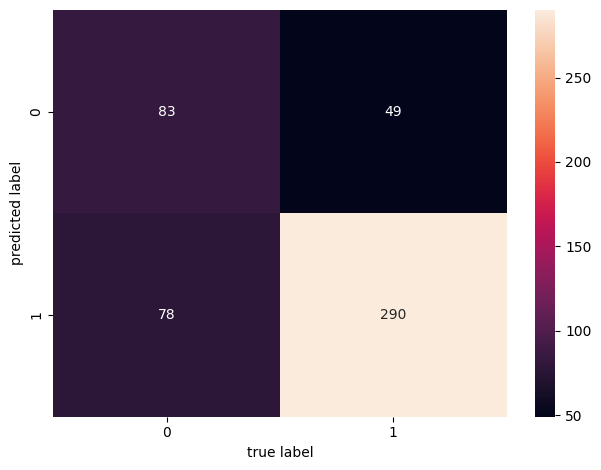


Classification Report:
               precision    recall  f1-score   support

       Above       0.52      0.63      0.57       132
       Below       0.86      0.79      0.82       368

    accuracy                           0.75       500
   macro avg       0.69      0.71      0.69       500
weighted avg       0.77      0.75      0.75       500



In [174]:
from seaborn import heatmap
# Extracting labels
labels = [classifier.classify(i[0]) for i in test_set]
y_test = [i[1] for i in test_set]

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n")
mat = confusion_matrix(y_test, labels)
heatmap(mat, annot=True, fmt='g')
plt.xlabel('true label')
plt.ylabel('predicted label')
save_fig("confusion_matrix")
plt.show()

# Classification Report
from sklearn import metrics
print("\nClassification Report:\n", metrics.classification_report(y_test, labels))

In [175]:
# Filter the dataset into two based on the 'Target' column
high_salary_data = df[df['Target'] == 'Above']['processed_FullDescription']
low_salary_data = df[df['Target'] == 'Below']['processed_FullDescription']

# Initialize CountVectorizer, note: stop_words='english' to exclude common English stop words
cv_high = CountVectorizer(stop_words='english', max_features=1000)
cv_low = CountVectorizer(stop_words='english', max_features=1000)

# Fit and transform the data for high salary and low salary categories
high_salary_dtm = cv_high.fit_transform(high_salary_data)
low_salary_dtm = cv_low.fit_transform(low_salary_data)

# Sum up the word counts for each feature for high salary and low salary data
high_salary_word_counts = np.sum(high_salary_dtm.toarray(), axis=0)
low_salary_word_counts = np.sum(low_salary_dtm.toarray(), axis=0)

# Get the feature names (words)
high_salary_features = cv_high.get_feature_names_out()
low_salary_features = cv_low.get_feature_names_out()

# Create dictionaries of word counts for high and low salary data
high_salary_word_freq = dict(zip(high_salary_features, high_salary_word_counts))
low_salary_word_freq = dict(zip(low_salary_features, low_salary_word_counts))

# Sort the dictionaries by word count to get the top 10 words
top10_high_salary_words = sorted(high_salary_word_freq.items(), key=lambda x: x[1], reverse=True)[:10]
top10_low_salary_words = sorted(low_salary_word_freq.items(), key=lambda x: x[1], reverse=True)[:10]

top10_high_salary_words, top10_low_salary_words

([('experience', 1354),
  ('business', 1056),
  ('team', 1014),
  ('role', 819),
  ('client', 813),
  ('project', 806),
  ('management', 729),
  ('work', 725),
  ('development', 706),
  ('skill', 655)],
 [('experience', 3041),
  ('work', 2244),
  ('role', 2238),
  ('team', 2110),
  ('job', 1982),
  ('client', 1874),
  ('service', 1852),
  ('working', 1710),
  ('business', 1695),
  ('sale', 1680)])

# Model Improvement

In [176]:
from nltk import pos_tag, word_tokenize
from nltk.util import ngrams

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

def extract_extended_phrases(text):
    # Tokenize and POS tag
    tokens = word_tokenize(text.lower())
    tagged_tokens = pos_tag(tokens)
    
    # Generate bigrams and trigrams
    bi_grams = list(ngrams(tagged_tokens, 2))
    tri_grams = list(ngrams(tagged_tokens, 3))
    
    # Define patterns to look for in bigrams
    patterns = [
        ('JJ', 'NN'),  # Adjective-Noun
        ('NN', 'NN'),  # Noun-Noun
        ('RB', 'JJ'),  # Adverb-Adjective (assuming no check for negations here)
        ('VB', 'RB'),  # Verb-Adverb
        ('VB', 'NN')   # Verb-Noun
    ]
    
    # Define patterns to look for in trigrams
    tri_patterns = [
        ('JJ', 'NN', 'NN'),  # Adjective-Noun-Noun
        ('RB', 'JJ', 'NN'),  # Adverb-Adjective-Noun
        ('NN', 'IN', 'NN')   # Noun-Preposition-Noun
    ]
    
    # Extract phrases based on bigram patterns
    phrases = [' '.join([a, b]) for ((a, tag_a), (b, tag_b)) in bi_grams if (tag_a, tag_b) in patterns]
    
    # Extract phrases based on trigram patterns
    phrases += [' '.join([a, b, c]) for ((a, tag_a), (b, tag_b), (c, tag_c)) in tri_grams if (tag_a, tag_b, tag_c) in tri_patterns]
    
    return phrases


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\TYS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TYS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [177]:
# Assuming df is your DataFrame and it includes a 'processed_FullDescription' column for text
# and a 'Target' column for labels
documents = [(extract_extended_phrases(row['processed_FullDescription']), row['Target']) for index, row in df.iterrows()]


In [178]:
all_phrases = []
for document, _ in documents:
    # Since document is already a list, directly extend all_phrases with it
    all_phrases.extend(document)


In [179]:
# Calculate frequency distribution of these phrases
from nltk import FreqDist
all_phrases_freq = FreqDist(all_phrases)

# Select the most common phrases as features
word_features = [phrase for phrase, count in all_phrases_freq.most_common(2000)]


In [180]:
def document_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features[f'contains({word})'] = (word in document_words)
    return features


In [181]:
# Assuming you have a list of (document, label) pairs
featuresets = [(document_features(d, word_features), c) for (d,c) in documents]
train_set, test_set = featuresets[100:], featuresets[:100]


In [182]:
# Model 
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.77


Confusion Matrix:

Saving figure confusion_matrix_POS


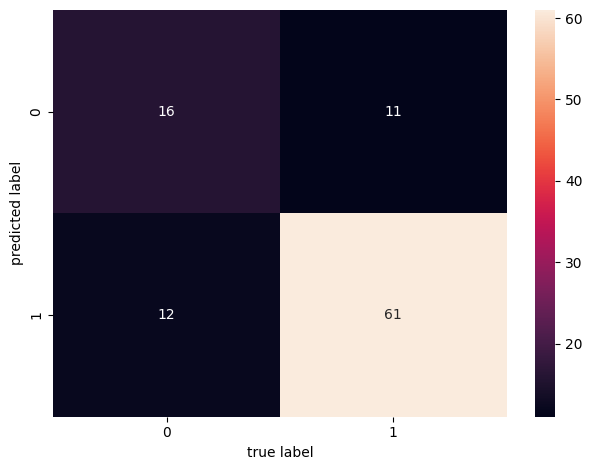


Classification Report:
               precision    recall  f1-score   support

       Above       0.57      0.59      0.58        27
       Below       0.85      0.84      0.84        73

    accuracy                           0.77       100
   macro avg       0.71      0.71      0.71       100
weighted avg       0.77      0.77      0.77       100



In [183]:
from seaborn import heatmap
# Extracting labels
labels = [classifier.classify(i[0]) for i in test_set]
y_test = [i[1] for i in test_set]

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n")
mat = confusion_matrix(y_test, labels)
heatmap(mat, annot=True, fmt='g')
plt.xlabel('true label')
plt.ylabel('predicted label')
save_fig("confusion_matrix_POS")
plt.show()

# Classification Report
from sklearn import metrics
print("\nClassification Report:\n", metrics.classification_report(y_test, labels))

# Incorporate other Features

In [184]:
category_vectorizer = CountVectorizer()
category_features = category_vectorizer.fit_transform(df['Category'])

In [185]:
location_vectorizer = CountVectorizer()
location_features = location_vectorizer.fit_transform(df['LocationNormalized'])

In [186]:
# Assuming the function extract_extended_phrases is defined as before
# Apply the function to the 'processed_FullDescription' column to extract POS-based features
df['POS_features'] = df['processed_FullDescription'].apply(extract_extended_phrases)

# Join the extracted features into a single string per document, if not already
df['POS_features'] = df['POS_features'].apply(lambda x: ' '.join(x))


In [187]:
pos_vectorizer = CountVectorizer()

# Fit and transform the POS extracted features
pos_features = pos_vectorizer.fit_transform(df['POS_features'])


In [188]:
from scipy.sparse import hstack

# Combine POS features and category features
combined_features = hstack([pos_features, location_features])


In [189]:
y = df['Target']  # Assuming 'Target' is the column with labels

# Split data
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.2, random_state=42)


In [190]:
classifier = MultinomialNB()

# Train the classifier
classifier.fit(X_train, y_train)

# Evaluate the classifier
accuracy = classifier.score(X_test, y_test)
print(f"Accuracy: {accuracy}") # The accuracy is 0.75 after including the location features


Accuracy: 0.764


In [191]:
combined_features2 = hstack([pos_features, category_features])

In [192]:
X_train, X_test, y_train, y_test = train_test_split(combined_features2, y, test_size=0.2, random_state=42)